In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generating Datasets

In [3]:
decision_lambda = lambda x1, x2: 1 if (x1 + (3 * x2) - 2) > 0 else -1

def gen_data():
    """
    Generates random data points and classifies them.
    """
    data = np.random.randint(low=-40, high=40, size=(100,2))
    classification = np.array([[decision_lambda(d[0], d[1])] for d in data])

    return np.hstack((data, classification))

In [4]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float) the percentage of the data you want to be TRAINING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split)
    
    training_set = shuffled[:training_count]
    test_set = shuffled[training_count:]
    
    return training_set, test_set

In [5]:
def split_pos_neg(data):
    """
    Returns two sets of positive, then negative examples (1's then -1's from the output column)
    """
    return data[data[:, -1]==1, :-1], data[data[:, -1]==-1, :-1]

In [6]:
# Find a balanced dataset of positive and negative samples
def get_balanced_data():
    ratio = -1
    while ratio == -1 or abs(1 - ratio) > 0.1:
        data = gen_data()
        pos, neg = split_pos_neg(data)

        # Check ratio of positive and negative samples
        ratio = len(pos) / len(neg)
    
    return data

# Perceptron (2 Input Linear Unit)

In [7]:
# To be used later when measuring performance
weight_updates = 0

class linear_unit():
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs + 1)
        
    def output(self, data_point):
        """
        Returns the linear combination of the input and this unit's weights
        """
        # total = w0*1 + w1x1 + w2x2 + ...
        data_with_bias = np.hstack((np.array([1]), data_point[:-1]))
        t = data_with_bias * self.weights
        t = np.sum(t)
        
        return t
        
    def delta_rule(self, data, learning_rate, epochs):
        """
        Performs the delta rule training for a given number of epochs using gradient descent
        """
        global weight_updates
        
        # From NN_MitchelChapter4-1.pdf on canvas          
        for ep in range(epochs): 
            delta_w = np.zeros(self.weights.shape[0])
            for d in data:
                d_with_bias = np.hstack((np.array([1]), d[:-1]))
                o = 1 if self.output(d) > 0 else -1
                delta_w = delta_w + learning_rate * (d[2] - o) * d_with_bias     
            self.weights = self.weights + delta_w
            
            if np.sum(delta_w) != 0:
                weight_updates += 1
                
        return weight_updates
        
    def delta_rule_stochastic(self, data, learning_rate, epochs):
        """
        Performs the delta rule training for a given number of epochs using stochastic gradient descent
        """
        global weight_updates
        
        # From NN_MitchelChapter4-1.pdf on canvas          
        for ep in range(epochs): 
            for d in data:
                d_with_bias = np.hstack((np.array([1]), d[:-1]))
                o = 1 if self.output(d) > 0 else -1
                temp_weights = self.weights + learning_rate * (d[2] - o) * d_with_bias  
                
                if (temp_weights != self.weights).any():
                    weight_updates += 1
                    
                self.weights = temp_weights
                
        return weight_updates
            
        
    def error(self, data):
        """
        Returns the sum squared error of the data using this unit's weights
        """
        sum = 0
        for d in data:
            o = 1 if self.output(d) > 0 else -1
            sum = sum + (d[2] - o)**2
        return sum

In [8]:
p = linear_unit(2)

In [9]:
data = get_balanced_data()
print(data[0])
print(p.weights)
print(p.output(data[0]))

# Train perceptron using gradient descent
p.delta_rule(data, 0.1, 50)
print(p.weights)
print(p.output(data[0]))

[-27 -28  -1]
[0.20981765 0.89970191 0.30475992]
-32.615411488353665
[  0.60981765  66.89970191 197.70475992]
-7341.415411488353


In [10]:
p2 = linear_unit(2)
data2 = get_balanced_data()

print(data[0])
print(p2.weights)
print(p2.output(data[0]))

# Train perceptron using stochastic gradient descent
p2.delta_rule_stochastic(data2, 0.1, 50)
print(p2.weights)
print(p2.output(data[0]))

[-27 -28  -1]
[0.73169831 0.21120879 0.62864974]
-22.573131537928795
[-29.86830169  12.61120879  39.62864974]
-1479.9731315379308


In [11]:
# Alex - Weights make sense now where 1st is negative and others are positive. (actual is [-2, 1, 3])

In [12]:
print(p.error(data))
print(p2.error(data2))

0
4


In [13]:
def plot_error_over_epochs(epochs):   
    """
    Plot the training error for up to some number of epochs
    """ 
    unit = linear_unit(2)
    
    x = np.arange(epochs)
    y = []
    data = get_balanced_data()
    for i in range(epochs):
        unit.delta_rule(data, 0.1, 1)
        y.append(unit.error(data))
        
    plt.plot(x, y, '--r')
    plt.xlabel('# of Epochs')
    plt.ylabel('Error')
    plt.title('Error vs Training Epochs')
    plt.show()

def plot_decision_surface():
    """
    Plot the decision surface for 5, 10, 50, and 100 epochs
    """ 
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    
    counter = 0
    for row in axs:
        for ax in row:
            # Get data
            data = get_balanced_data()
            pos, neg = split_pos_neg(data)
            
            # Set axis limits
            ax.set_xlim(-40, 40)
            ax.set_ylim(-40, 40)
            
            # Train linear unit
            unit = linear_unit(2)
            if counter == 0:
                unit.delta_rule(data, .1, 5)
                ax.set_title('5 Epochs')
            elif counter == 1:
                unit.delta_rule(data, .1, 10)
                ax.set_title('10 Epochs')
            elif counter == 2:
                unit.delta_rule(data, .1, 50)
                ax.set_title('50 Epochs')
            else:
                unit.delta_rule(data, .1, 100)
                ax.set_title('100 Epochs')
            
            # Plot decision boundary
            x = np.arange(-40, 40)
            yf = lambda x: ((unit.weights[1] / unit.weights[2]) * -x) - unit.weights[0]
            y = [yf(d) for d in x]
            ax.plot(x, y, color='orange')
            ax.fill_between(x, y, 40, color='lightcoral')
            ax.fill_between(x, y, -40, color='lightblue')
            
            # Overlay training data
            ax.scatter(pos[:, 0], pos[:, 1], color='red')
            ax.scatter(neg[:, 0], neg[:, 1], color='blue')
            
            counter += 1
    
    plt.show()
    
def plot_error_training_rates():
    
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    x = np.arange(50)
    
    counter = 0
    for row in axs:
        for ax in row:
    
            if counter == 0:
                lr = 0.1
                ax.set_title('Learning Rate = 0.1')
            elif counter == 1:
                lr = 0.01
                ax.set_title('Learning Rate = 0.01')
            elif counter == 2:
                lr = 0.001
                ax.set_title('Learning Rate = 0.001')
            elif counter == 3:
                lr = 0.0001
                ax.set_title('Learning Rate = 0.0001')
    
            unit = linear_unit(2)
            y = []
            data = get_balanced_data()
            for i in range(50):
                unit.delta_rule(data, lr, 1)
                y.append(unit.error(data))
        
            ax.plot(x, y, '--r')
            counter += 1
    
    #plt.xlabel('# of Epochs')
    #plt.ylabel('Error')
    plt.show()

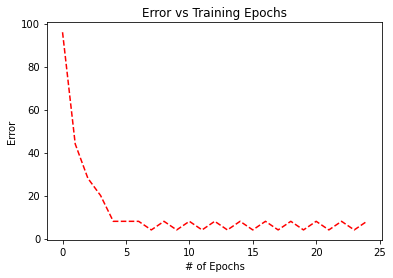

In [14]:
plot_error_over_epochs(25)

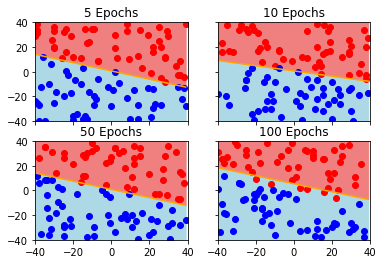

In [15]:
plot_decision_surface()

In [16]:
# Will -Not sure if we can scale these up or something. Also sometimes the 100 epochs one just freaks out and has crazy high error.

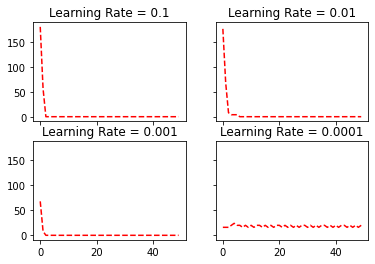

In [17]:
plot_error_training_rates()

In [18]:
# TODO: analysis for learning rate
# Looks like 0.001 is good?

In [19]:
import timeit

weight_updates = 0

data = get_balanced_data()

# Train perceptron using batch gradient descent
p = linear_unit(2)
time = timeit.timeit(lambda: p.delta_rule(data, 0.001, 50), number=1)

print('Epochs: 50')
print('Learning Rate: 0.001\n')

print('Batch Training:')
print(f'\tExecution Time: {time}')
print(f'\tNum of Weight Updates: {weight_updates}\n')

weight_updates = 0

# Train perceptron using stochastic gradient descent
p = linear_unit(2)
time = timeit.timeit(lambda: p.delta_rule_stochastic(data, 0.001, 50), number=1)

print('Stochastic Training:')
print(f'\tExecution Time: {time}')
print(f'\tNum of Weight Updates: {weight_updates}\n')

Epochs: 50
Learning Rate: 0.001

Batch Training:
	Execution Time: 0.12686490000000017
	Num of Weight Updates: 14

Stochastic Training:
	Execution Time: 0.15222490000000022
	Num of Weight Updates: 122



## Decaying Adaptive Rate

In [20]:
def learning_rate_decay(initial_learning_rate, epoch, decay_rate):
    return decay_rate**epoch * initial_learning_rate

def plot_error_decay(epochs):   
    """
    Plot the training error for up to some number of epochs of constant vs decay
    """ 
    data = get_balanced_data()
    unit = linear_unit(2)
    
    x = np.arange(epochs)
    y = []
    for i in range(epochs):
        unit.delta_rule(data, 0.001, 1)
        y.append(unit.error(data))        
    plt.plot(x, y, '--r')
    
    unit2 = linear_unit(2)
    
    x2 = np.arange(epochs)
    y2 = []
    for i in range(epochs):
        learning_rate = learning_rate_decay(0.1, i, 0.8)
        unit2.delta_rule(data, learning_rate, 1)
        y2.append(unit2.error(data))
    plt.plot(x2, y2, '--b')
    
    plt.xlabel('# of Epochs')
    plt.ylabel('Error')
    plt.legend(['Constant Rate', 'Decaying Rate'])
    plt.title('Error vs Training Epochs')
    plt.show()

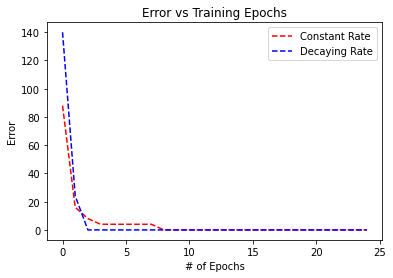

In [21]:
plot_error_decay(25)

In [22]:
# Overall decay worse at first and then is the same or slightly better than a constant rate
# TODO analysis

## Adaptive Learning Rate

In [23]:
def learning_rate_adaptive(learning_rate, error_diff, t, d, D):
    """
    error_diff: new error - previous error
    t: threshold
    d: multiplier if above threshold
    D: multiplier if less than threshold
    return new learning rate, keep new weights
    """     
    if error_diff >= t:
        return learning_rate * d, False
    else:
        return learning_rate * D, True

def plot_error_adaptive(epochs):   
    """
    Plot the training error for up to some number of epochs of constant vs adaptive
    """ 
    data = get_balanced_data()
    unit = linear_unit(2)
    
    x = np.arange(epochs)
    y = []
    for i in range(epochs):
        unit.delta_rule(data, 0.001, 1)
        y.append(unit.error(data))        
    plt.plot(x, y, '--r')
    
    unit2 = linear_unit(2)
    
    x2 = np.arange(epochs)
    y2 = []
    prev_error = unit2.error(data)
    learning_rate = 0.1
    for i in range(epochs):
        prev_weights = np.copy(unit2.weights)
        unit2.delta_rule(data, learning_rate, 1)        
        learning_rate, keep_weights = learning_rate_adaptive(learning_rate, unit2.error(data) - prev_error, 0.2, 0.9, 1.1)
        prev_error = unit2.error(data)
        if not keep_weights:
            unit2.weights = prev_weights
        y2.append(unit2.error(data))
    plt.plot(x2, y2, '--b')
    
    plt.xlabel('# of Epochs')
    plt.ylabel('Error')
    plt.legend(['Constant Rate', 'Decaying Rate'])
    plt.title('Error vs Training Epochs')
    plt.show()

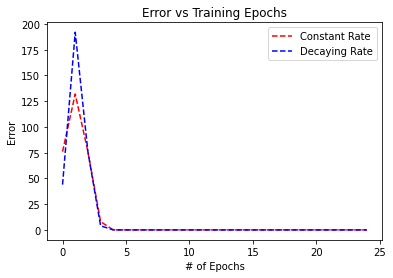

In [24]:
plot_error_adaptive(25)

In [25]:
# Overall adaptive increases in error and then is the same or slightly better than a constant rate
# TODO analysis